In [ ]:
! pip install langchain_core langchain_openai langgraph

In [10]:
import os, getpass
def set_env(key: str,env_var_name: str):
    os.environ[env_var_name] = key

api_key = getpass.getpass("Enter your OpenAI API Key: ")
set_env(api_key, "OPENAI_API_KEY")

In [20]:
#configuring llm
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model='gpt-4o-2024-08-06', api_key=api_key)

In [20]:
#aumenting LLM : preparing the llm in the way it will be used. (example - fine tuning, structured output , system prompt etc)
#example: I need to have structured output , i will augment the llm to return structured output
from pydantic import BaseModel,Field
class search_input(BaseModel):
    query: str = Field(None,title="mathematical expression that will be used to search for the answer")
    justification: str = Field(None,title="justification for the answer")
    
structured_llm=model.with_structured_output(search_input)

output = structured_llm.invoke("what is the value of 2 added with 5 then the result is multiplied by 3")
print(output)
print(output.query)
print(output.justification)

query='(2 + 5) * 3' justification="To find the value of the given expression, we first perform the addition inside the parentheses and then multiply the result by 3.\\n\\nLet's break down the computation step-by-step:\\n1. **Addition Step:**\\n   - Add the numbers inside the parentheses (2 + 5):\\n   - 2 + 5 = 7\\n\\n2. **Multiplication Step:**\\n   - Multiply the result from the addition by 3:\\n   - 7 * 3 = 21\\n\\nTherefore, the final result of the expression is 21."
(2 + 5) * 3
To find the value of the given expression, we first perform the addition inside the parentheses and then multiply the result by 3.\n\nLet's break down the computation step-by-step:\n1. **Addition Step:**\n   - Add the numbers inside the parentheses (2 + 5):\n   - 2 + 5 = 7\n\n2. **Multiplication Step:**\n   - Multiply the result from the addition by 3:\n   - 7 * 3 = 21\n\nTherefore, the final result of the expression is 21.


In [25]:
def addition(a:int,b:int):
    return a+b

def multiplication(a:int,b:int):
    return a*b

def divide(a:int,b:int):
    return a/b

def subtraction(a:int,b:int):
    return a-b

def power(a:int,b:int):
    return a**b

llm_with_tools=model.bind_tools([addition,multiplication,divide,subtraction,power])

# testing 
output = llm_with_tools.invoke("what is the value of 2 added with 5 then the result is multiplied by 3")
# print(output)
print(output.tool_calls)

[{'name': 'addition', 'args': {'a': 2, 'b': 5}, 'id': 'call_pxLQeVi8K7kiBXLywWOjnZDP', 'type': 'tool_call'}, {'name': 'multiplication', 'args': {'a': 7, 'b': 3}, 'id': 'call_s6osIJH2Lfzsg3RbcKgp2jyZ', 'type': 'tool_call'}]


In [32]:
# jokes example 
# step 1 - defining graph state
from typing_extensions import TypedDict

class graph_state(TypedDict):
    topic : str
    joke : str
    improved_joke : str
    final_joke : str

In [33]:
# step -2 building the graph elements
#nodes
def generate_joke(state:graph_state):
    msg=model.invoke(f"tell me a joke about {state['topic']}")
    return {'joke':msg.content}

def improve_joke(state:graph_state):
    msg=model.invoke(f"improve the joke {state['joke']}")
    return {'improved_joke':msg.content}

def finalize_joke(state:graph_state):
    msg=model.invoke(f"finalize the joke {state['improved_joke']}")
    return {'final_joke':msg.content}

#coditional_node
def check_punchline(state:graph_state):
    # 'this is called a conditional node / gate'
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    else:
        return "Fail"

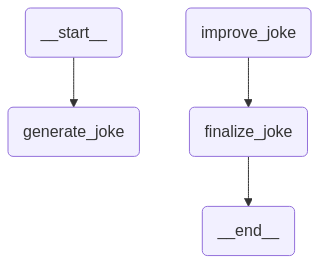

In [38]:
# Step 3 - Building the workflow using langgraph
from langgraph.graph import StateGraph,START,END 
from IPython.display import Image,display

workflow = StateGraph(graph_state)
workflow.add_node("generate_joke",generate_joke)
workflow.add_node("improve_joke",improve_joke)
workflow.add_node("finalize_joke",finalize_joke)

workflow.add_edge(START,"generate_joke")
# workflow.add_conditional_edge("generate_joke",check_punchline,{"Pass":"improve_joke","Fail":END})
workflow.add_edge("improve_joke","finalize_joke")
workflow.add_edge("finalize_joke",END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [41]:
# step 4 - executing the workflow
state=chain.invoke({"topic":"elephant"})
print("initial joke",state['joke'])
if 'improved_joke' in state:
    print("improved joke",state['improved_joke'])
    print("final joke",state['final_joke'])
else : 
    print("Failed at conditional node")
 

initial joke Why don't elephants use computers?

Because they're afraid of the mouse!
Failed at conditional node
